In [124]:
import numpy as np
from numpy import matmul, transpose, matrix, multiply, divide,sqrt,diag,log,pi
import matplotlib.pyplot as plt
from numpy.linalg import inv
import pandas as pd
from numpy.linalg import eigvals, eig
from scipy.special import gammaln
import sys
from scipy.cluster.hierarchy import dendrogram, linkage
import pickle
import datetime
from numpy import transpose as t
%matplotlib inline  


In [73]:
def ltpdf(x,m,w,n,D):
    q = x.shape[0]
    C = transpose(np.linalg.cholesky(D));
    e = inv(C)@(x-m);
    d = n+q-1;
    ltpdf = q*np.log(2)/2 - q*np.log(2*pi*w)/2 -sum(np.log(diag(C))) -(d+1)*np.log(1+(transpose(e)@e)/w)/2;
    ltpdf += sum(gammaln(1 + d - np.array(list(range(0,q))))/2) - sum(gammaln(d - np.array(list(range(0,q))))/2)
    return(ltpdf)

In [74]:
# M.W example data
#data = pd.read_excel('/Users/mueric35/Desktop/Share/FXCommData2000-2011.xlsx')
#del data['USD-SGD']
#Y = matrix(data)
#Y = transpose(Y[1:,]/Y[:-1,:]-1)*100
#q,T = Y.shape

In [75]:
# data of daily difference

#df = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/GTdata/df_all_daily.csv', index_col= 0)
#Y = 100 * matrix(df.iloc[:,[i-1 for i in [7 , 72 , 78 , 81 , 93 ,103 ,107 ,125 ,127 ,130 ,141 ,143 ,151 ,152]]])
#T,q = Y.shape
#Y = transpose(Y)

## standardize
#Y = Y - np.mean(Y,axis = 1)
#Y = Y/np.std(Y,axis = 1)


In [156]:
# data for log transformation
df = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/GTdata/df_all_daily_raw.csv', index_col= 0)
Y = matrix(df.iloc[:,[i-1 for i in [7 , 72 , 78 , 81 , 93 ,103 ,107 ,125 ,127 ,130 ,141 ,143 ,151 ,152]]])
T,q = Y.shape
Y = transpose(Y)
Y[Y == 0] = 1
Y = log(Y)

In [173]:
date = df.index 
Date = np.array([datetime.datetime.strptime(i, '%Y-%m-%d').date() for i in list(date)]).reshape((T,1))

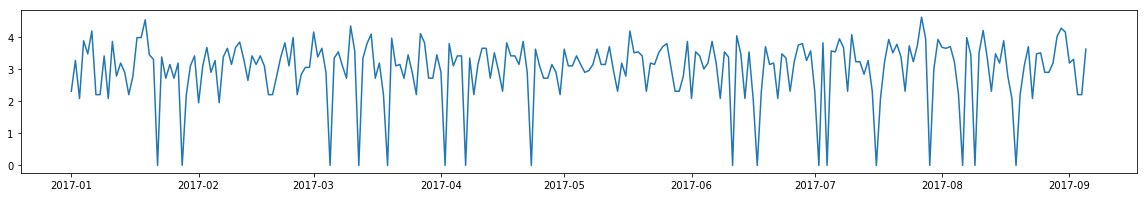

In [152]:
plt.figure(figsize=(20,3))
plt.plot(Date,t(Y[0,:]));

In [78]:
# select variable from Hierachical Clustering ... Done in R
name = [df.columns[i-1] for i in [7 , 72 , 78 , 81 , 93 ,103 ,107 ,125 ,127 ,130 ,141 ,143 ,151 ,152]]
name

['community bank',
 'the great depression',
 'gold stock price',
 'associated press',
 'berkeley county',
 '1929',
 'berkeley electric',
 'massachusetts',
 'gold stock',
 'cost stock',
 'procter gamble stock',
 'political quiz',
 'gold price',
 'bitcoin price']

In [159]:
## only for local level , thus p = 1
class multi_filtering(object):
    
    def __init__(self, Y  ,m0 = matrix(np.ones([1,q])),
                 c0 = 0.01 , n0 = 3 ,beta = 0.9, delta = 0.9, backwardSmooth = False, Print = True):
        
        #change discounts to assess, compare marginal likelihood
        p=1;   
        F=np.matrix(np.ones([1,T]));

        #delta = 0.9; # discount level
        #beta = 0.9;  # discount volatility

        n0 = n0 ; 
        h0=n0+q-1; 
        D0=np.matrix(h0*np.identity(q));

        z = np.ones([p,q]);  
        zq=np.zeros([q,1]); 

        M0 = m0; 
        r=0.99; # priors
        Mt = M0;

        C0= np.matrix( c0 *np.identity(p))
        Ct=C0;        # initial Theta prior 

        n = n0; 
        h=h0;
        D = D0; 
        St=D/h;         # initial Sigma prior


        sMt = np.ones([p,q,T]); 
        sCt=np.zeros([p,p,T]);
        sdCt=np.zeros([p,q,T]);
        sSt=np.zeros([q,q,T]);  
        snt=np.zeros(T);
        sloglik=np.zeros(T); 

        sEt = matrix(np.zeros([q,T]))

        eigs = np.zeros([q,T])
        eig_vec = []
        
        self.M0 = M0
        self.C0 = C0
        self.S0 = St
        self.delta = delta
        self.beta = beta
        
        if Print:
            print('Start forward filtering...')
        
        # # forward filtering: 
        for t in range(T):
            ft = np.matrix(transpose(Mt) @ F[:,t])
            et = Y[:,t] - ft;
            Rt = Ct/delta; 
            h  = beta*h; 
            n=h-q+1; 
            D = beta*D;  
            snt[t]=n;  
            qvt = 1 + transpose(F[:,t])@Rt@F[:,t]; 
            sEt[:,t] = transpose(np.squeeze(et)/np.sqrt(qvt*np.diag(St)))

            At = Rt@F[:,t]/qvt;
            h += 1; 
            n += 1; 
            D += et @ transpose(et)/qvt
            St=D/h; 
            St=(St+transpose(St))/2; 
            Mt = Mt + At@transpose(et);
            Ct = Rt - At@np.transpose(At)*qvt;

            #
            sloglik[t] = ltpdf(et,zq,qvt,n,D);    

            # PCA

            eig_vals, eig_vecs = eig(St)
            eig_vals_sorted = np.sort(eig_vals)[::-1]
            eig_vecs_sorted = eig_vecs[:, eig_vals.argsort()[::-1]]
            eigs[:,t] = eig_vals_sorted

            eig_vec.append(eig_vecs_sorted)
            # save
            sCt[:,:,t]=Ct;
            sSt[:,:,t]=St; 
            sMt[:,:,t] = Mt; 
            sdCt[:,:,t] = sqrt(transpose(diag(Ct)*diag(St)));
        
        
        if Print:
            print('Start Backward Smoothing...')
                
        if backwardSmooth:
            # reverse smoothing 
            K=inv(sSt[:,:,-1]); 
            n=snt[:-1]; 
            Mt = sMt[:,:,-1]; 
            Ct = sCt[:,:,-1]; 

            for t in list(range(1,T-1))[::-1]:
                K=(1-beta)*inv(sSt[:,:,t])+beta*K;         
                St = inv(K); 
                sSt[:,:,t]=St;  
                Mt = (1-delta)*sMt[:,:,t] +delta*Mt;  
                sMt[:,:,t] = Mt; 
                Ct = (1-delta)*sCt[:,:,t] + np.power(delta,2)*Ct;    
                sCt[:,:,t] = Ct; 
                sdCt[:,:,t] = sqrt(diag(Ct)* transpose(diag(St)));
            
        self.sCt = sCt
        self.sSt = sSt
        self.sMt = sMt
        self.sdCt = sdCt
        self.eigs = eigs
        self.sloglik = sloglik
        self.eig_vec = eig_vec
        
        if Print:
            print('Finished...')

In [160]:
# Tuned Beta and Delta
Beta = np.round(np.linspace(start=0.9,stop= 1,num=10),2)
Delta = np.round(np.linspace(start=0.9,stop= 1,num=10),2)


In [161]:
# Tuned Beta and Delta
loglik = {}
for beta in Beta:
    for delta in Delta:
        filt = multi_filtering(Y = Y, beta = beta, delta=delta, Print = False)
        loglik.update({str(beta) + '-' +str(delta):filt.sloglik})

/Users/mueric35/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: ComplexWarning: Casting complex values to real discards the imaginary part


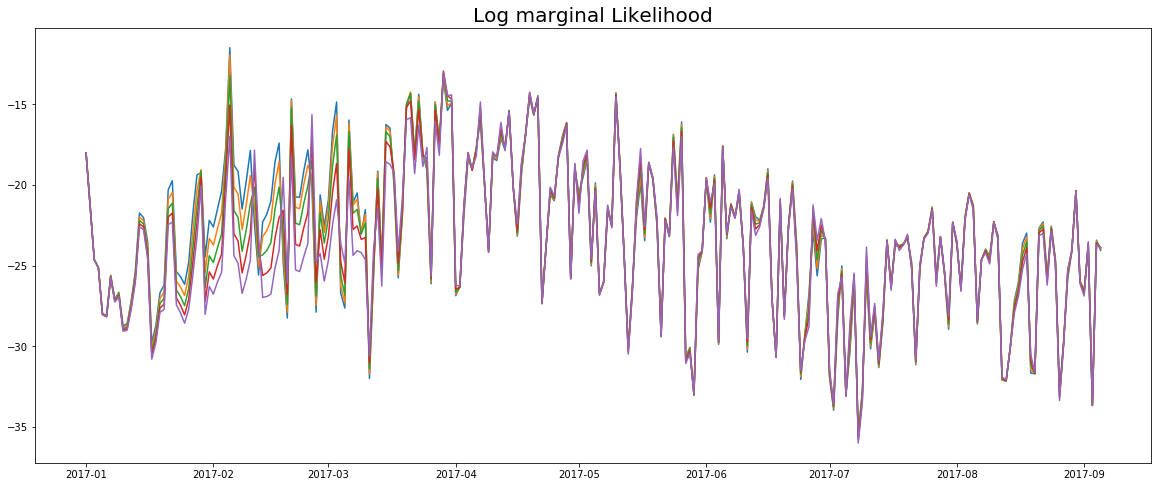

In [167]:
# log marginal Likelihood
plt.figure(figsize=(20,8))
for i in list(loglik.keys())[:5]:
    plt.plot(Date,loglik.get(i))
    plt.title('Log marginal Likelihood', fontsize = 20);
    # add legend

In [163]:
## Report optimal Delta and Beta

In [164]:
cumsum_log = []
for key, item in loglik.items():
    cumsum_log.append(np.cumsum(item)[-1])
list(loglik.keys())[cumsum_log.index(max(cumsum_log))]

'0.97-0.9'

In [165]:
# Model with beta* and delta*
model = multi_filtering(Y = Y , beta = 0.97, delta = 0.9, backwardSmooth = False)
sSt = model.sSt
sdCt = model.sdCt
sMt = model.sMt
sloglik = model.sloglik
eigs = model.eigs
eigs_vec = model.eig_vec

Start forward filtering...


/Users/mueric35/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: ComplexWarning: Casting complex values to real discards the imaginary part


Start Backward Smoothing...
Finished...


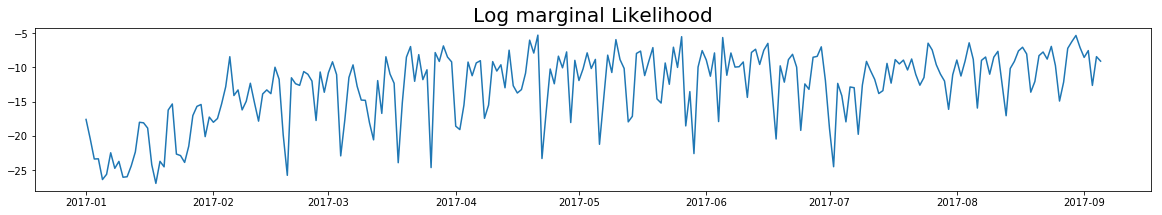

In [168]:
plt.figure(figsize=(20,3))
plt.plot(Date,sloglik);
plt.title('Log marginal Likelihood', fontsize = 20);

## Eigenvalue

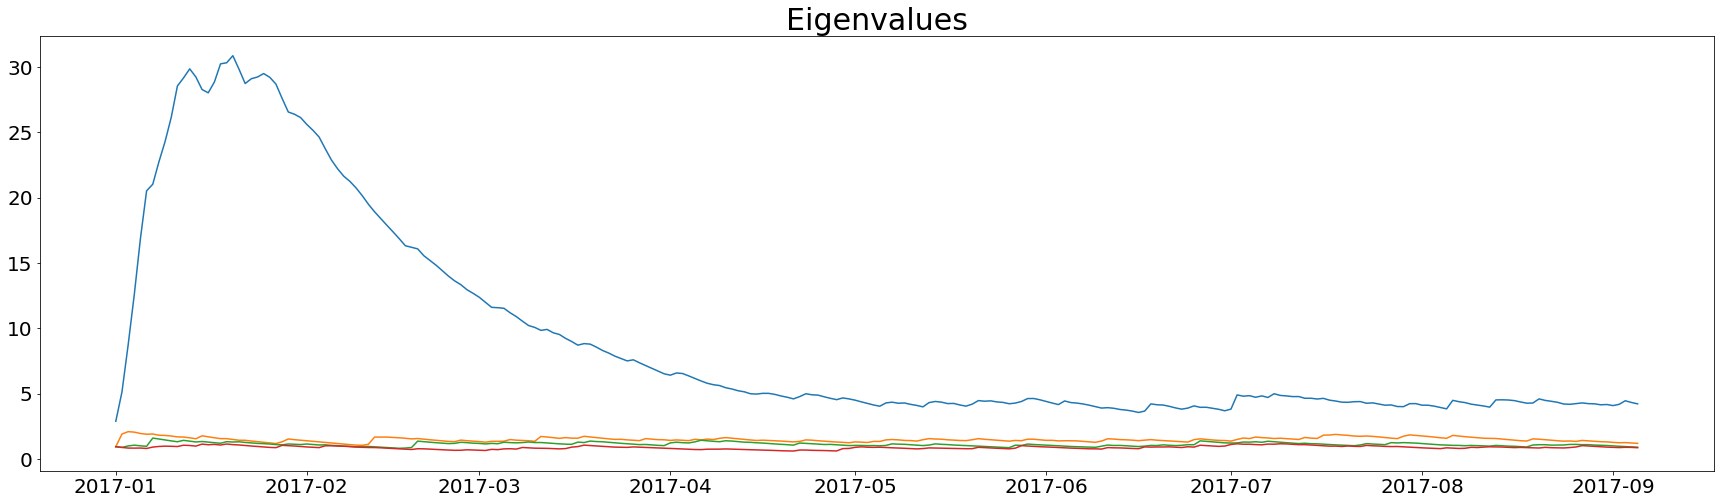

In [170]:
plt.figure(figsize=(30,8))
for i in range(4):
    plt.plot(Date,np.array(eigs[i,:]));
    plt.tick_params(labelsize=20)
    plt.title('Eigenvalues', fontsize = 30)



## Cumulative Variance Explained by components

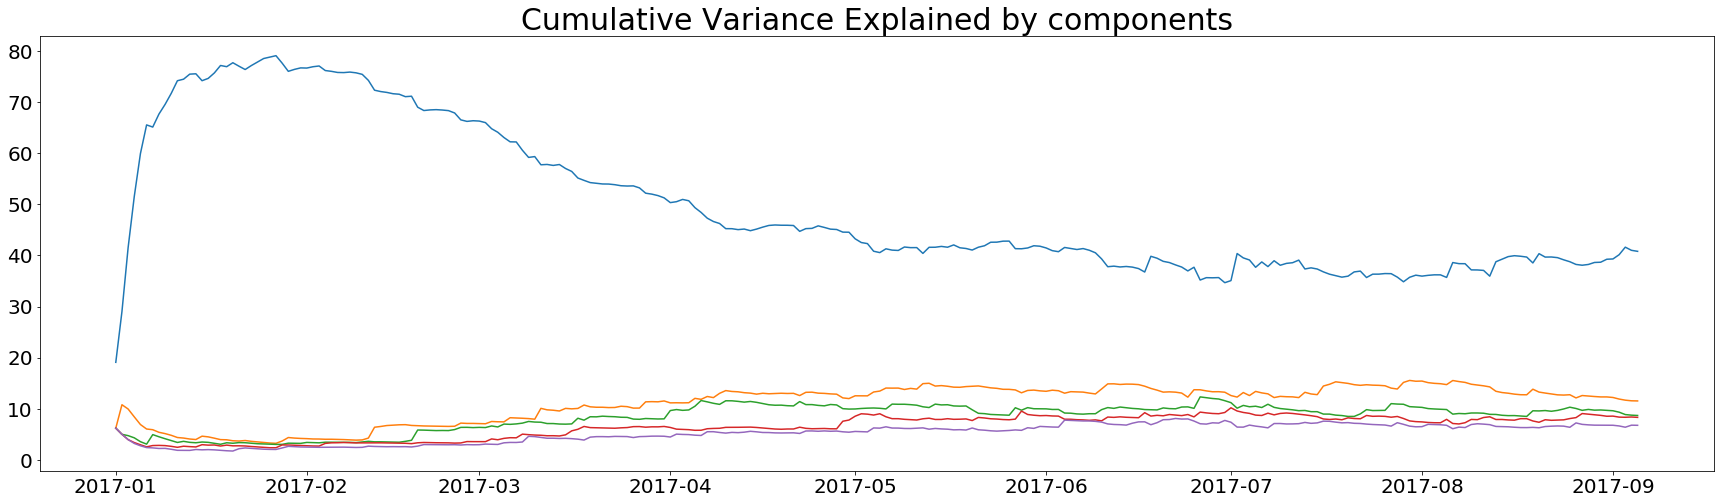

In [171]:
eigs_frac = 100*eigs/np.sum(eigs,axis = 0)
plt.figure(figsize=(30,8))
for i in range(5):
    plt.plot(Date,eigs_frac[i,:])
    plt.tick_params(labelsize=20)
    plt.title('Cumulative Variance Explained by components', fontsize = 30)



## Plot Data

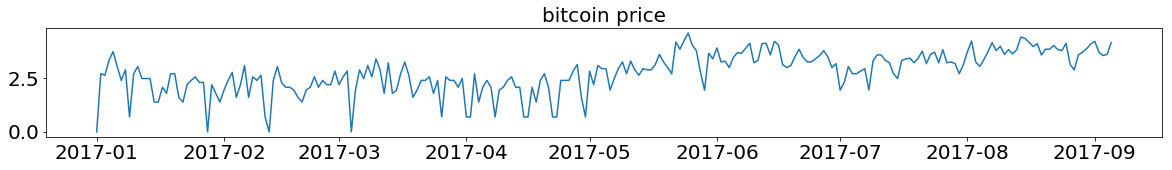

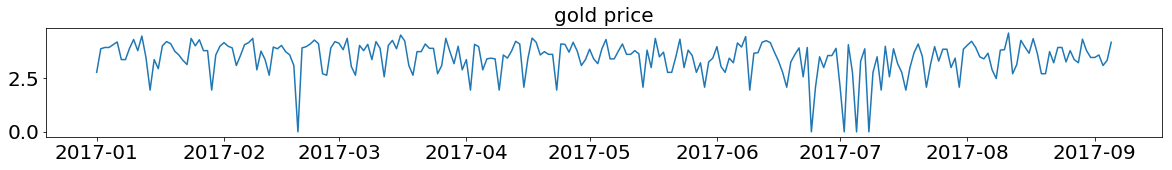

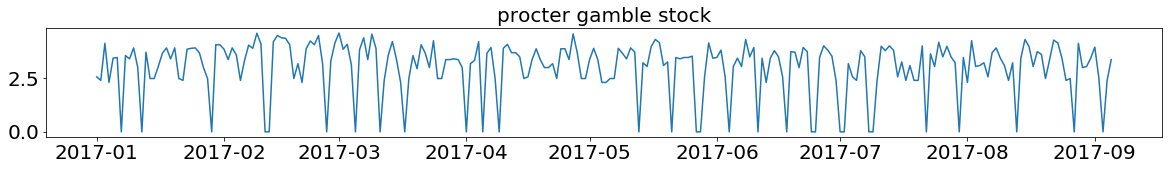

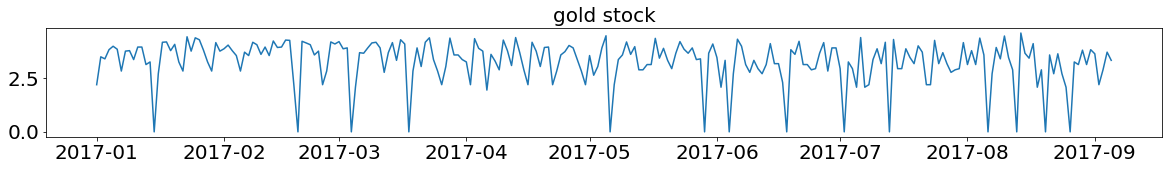

In [174]:
index = 13

def plot_data(index):
    plt.figure(figsize=(20,2))
    topic = name[index]
    plt.plot(Date,t(Y[index,:]));    
    plt.title(str(topic), fontsize = 20)
    plt.tick_params(labelsize=20)

plot_data(index)
plot_data(12)
plot_data(10)
plot_data(8)

## Plot Volatility 

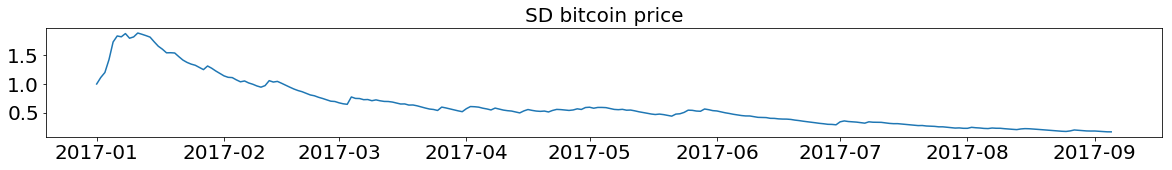

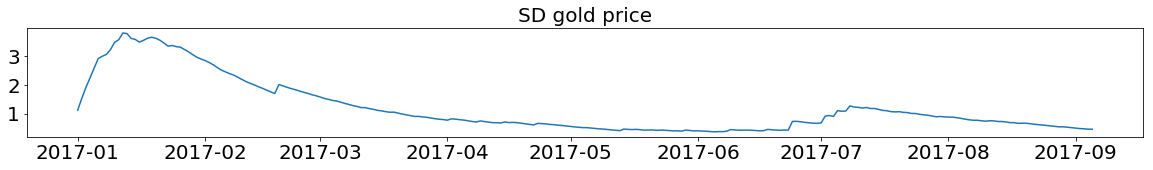

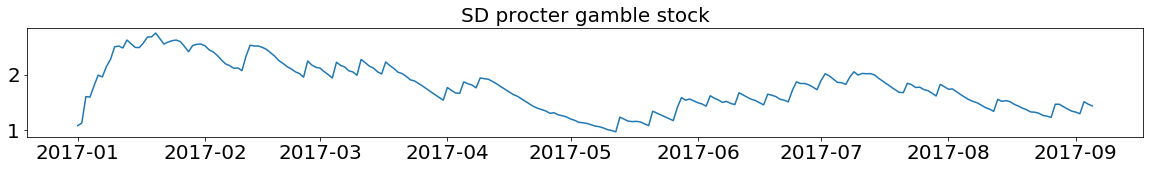

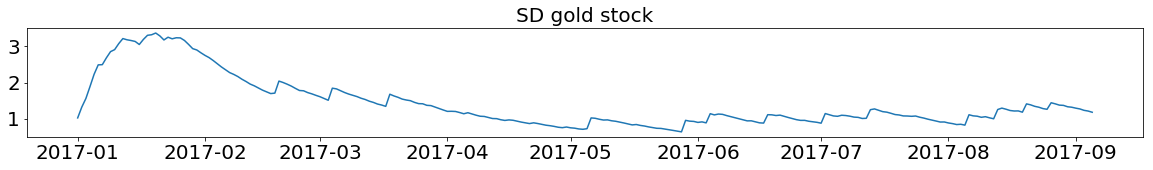

In [176]:
def plot_vol(index):
    topic = name[index]
    plt.figure(figsize=(20,2))
    plt.plot(Date,sSt[index,index,:]);
    plt.title( 'SD '+ str(topic), fontsize = 20)
    plt.tick_params(labelsize=20)

plot_vol(index)
plot_vol(12)
plot_vol(10)
plot_vol(8)



## Plot Correlation

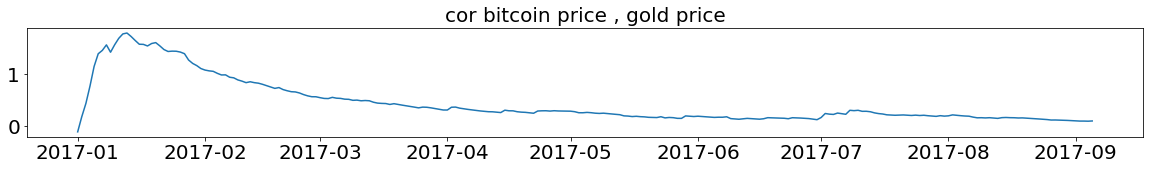

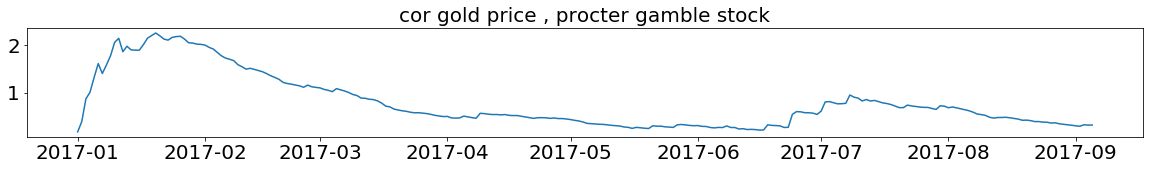

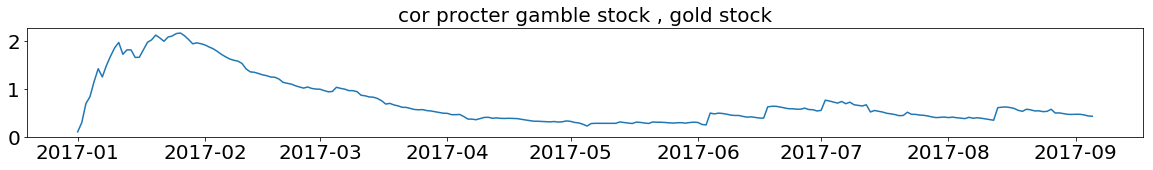

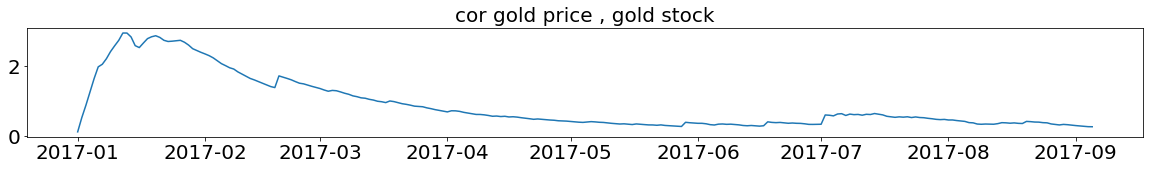

In [177]:
def plot_cor(index):
    topic = [name[i] for i in index]
    plt.figure(figsize=(20,2))
    plt.plot(Date,sSt[index[0],index[1],:]);
    title = ' , '.join(t for t in topic)
    plt.title('cor ' + title, fontsize = 20)
    plt.tick_params(labelsize=20)
plot_cor([13,12])
plot_cor([12,10])
plot_cor([10,8])
plot_cor([12,8])


## Plot State

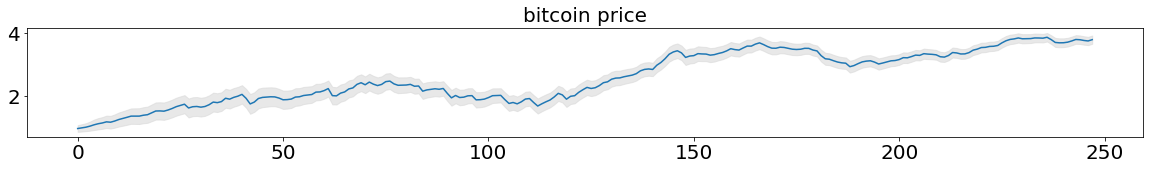

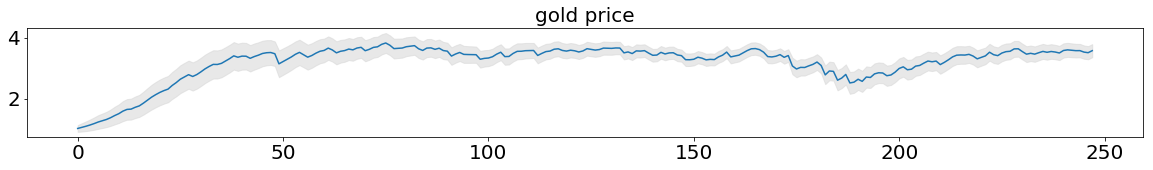

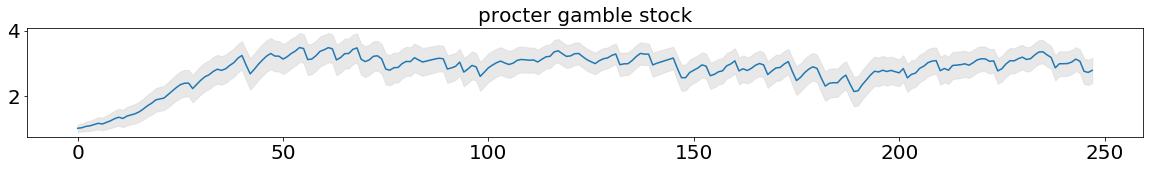

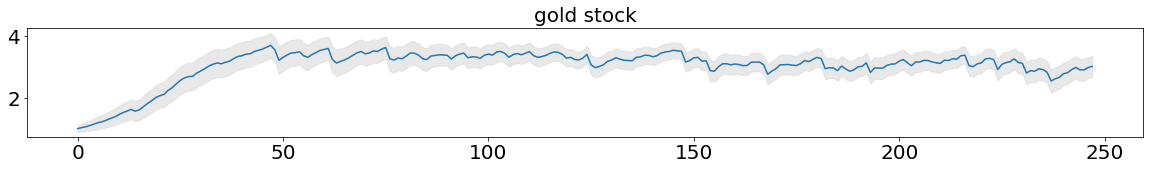

In [181]:
def plot_mt(index):
    plt.figure(figsize=(20,2))
    sct= np.squeeze(sdCt[0,index,:]);
    higher = np.squeeze(sct + sMt[0,index,:])
    lower = np.squeeze(sMt[0,index,:] - sct)

    plt.fill_between(range(len(np.array(higher))),
                     np.array(higher).flatten().tolist(), 
                     np.array(lower).flatten().tolist(), color='lightgray', alpha=0.5)
    topic = name[index]
    plt.plot(sMt[0,index,:]);
    plt.title(str(topic), fontsize = 20)
    plt.tick_params(labelsize=20)
plot_mt(index)
plot_mt(12)
plot_mt(10)
plot_mt(8)

## Projection

In [182]:
def project_component(Y,eigs_vec,n):
    component = np.zeros([len(eigs_vec),n])
    for i in range(len(eigs_vec)):
        component[i,:] = transpose(Y[:,i]) @ eigs_vec[i][:,0:n]
    return(component)

In [183]:
component = project_component(Y,eigs_vec,3)

/Users/mueric35/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


## use Cluster result

In [189]:
with open('cluster_index', 'rb') as handle:
    cluster = pickle.load(handle)


/Users/mueric35/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/mueric35/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


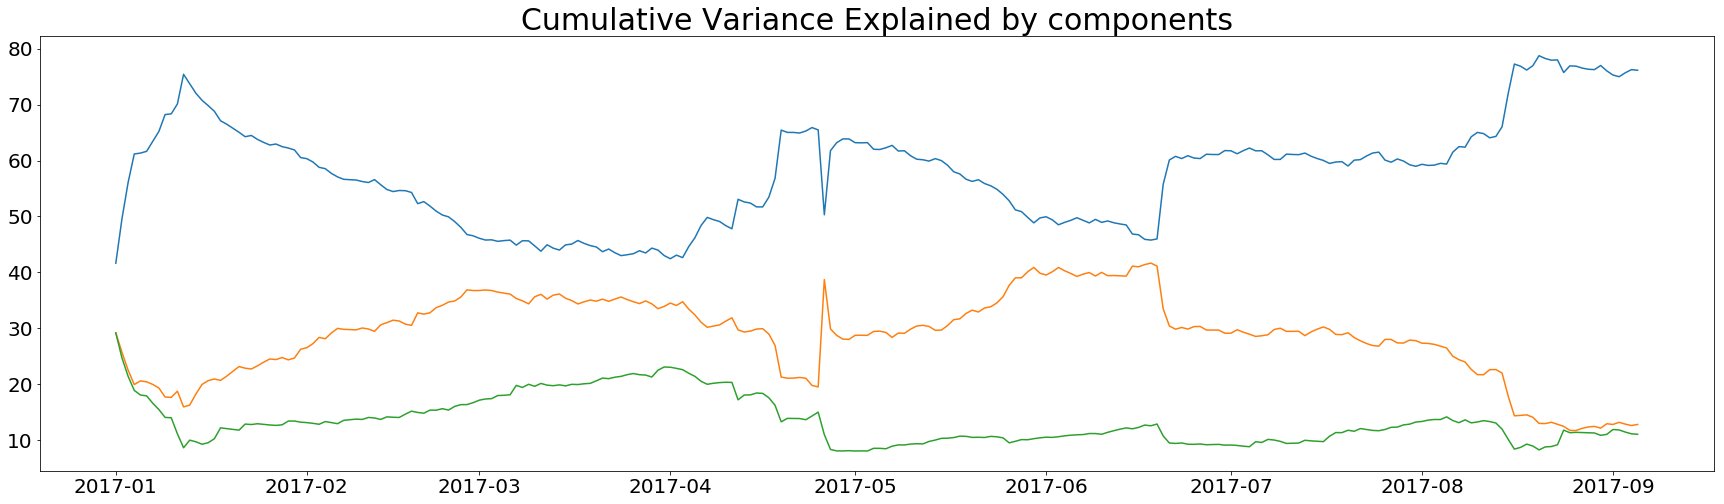

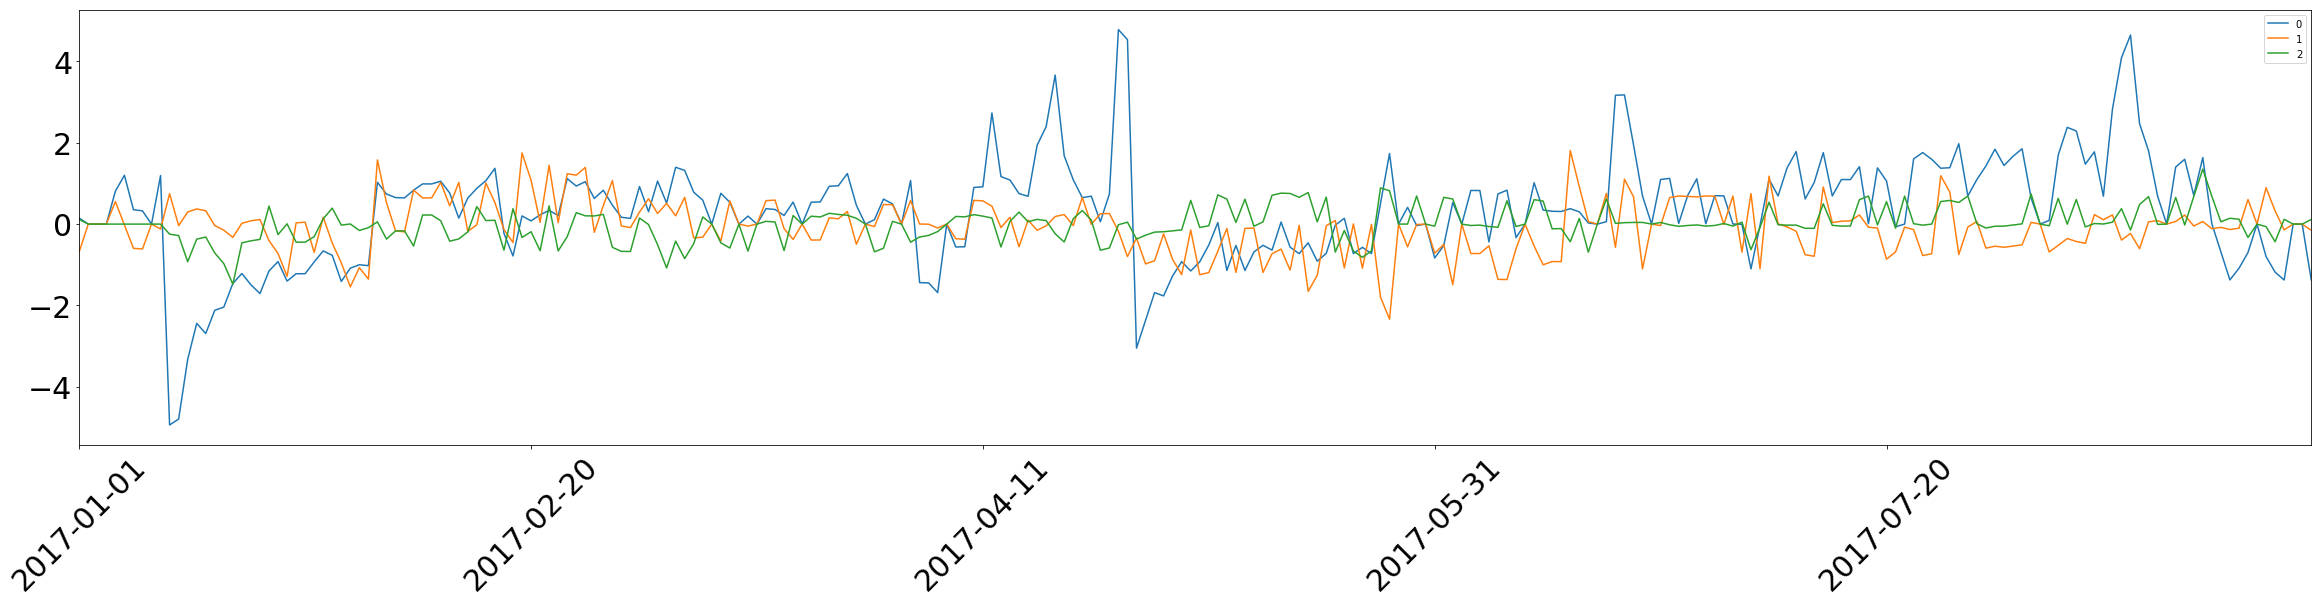

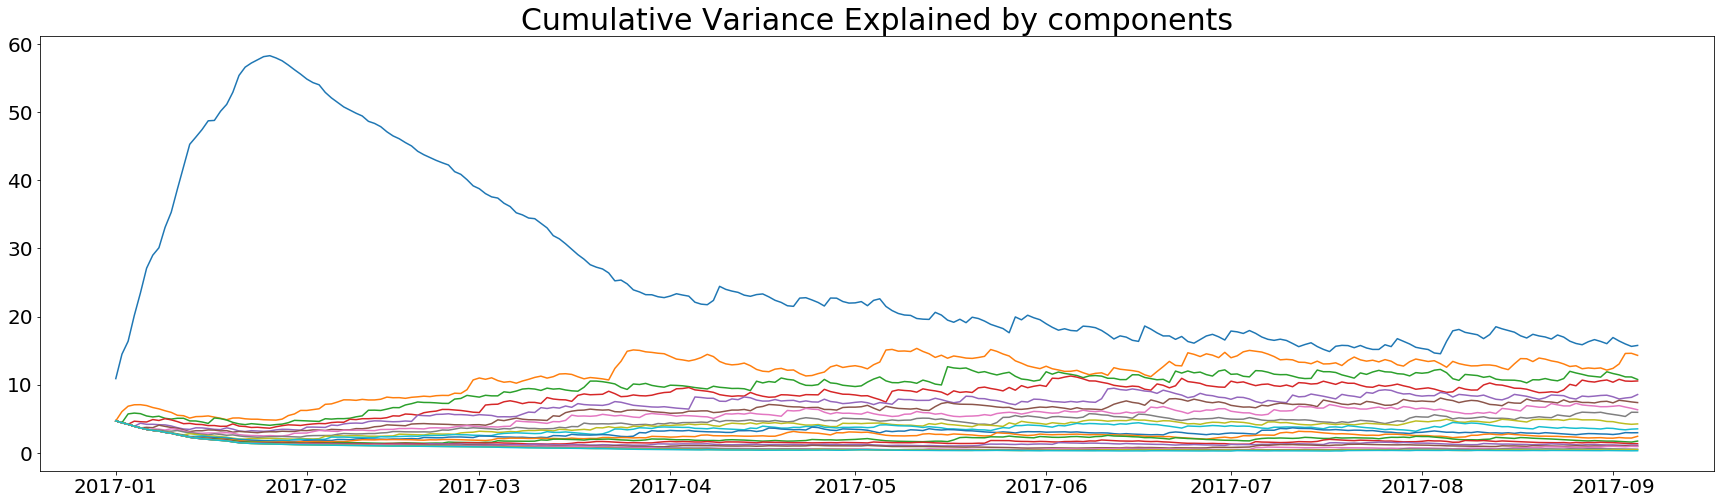

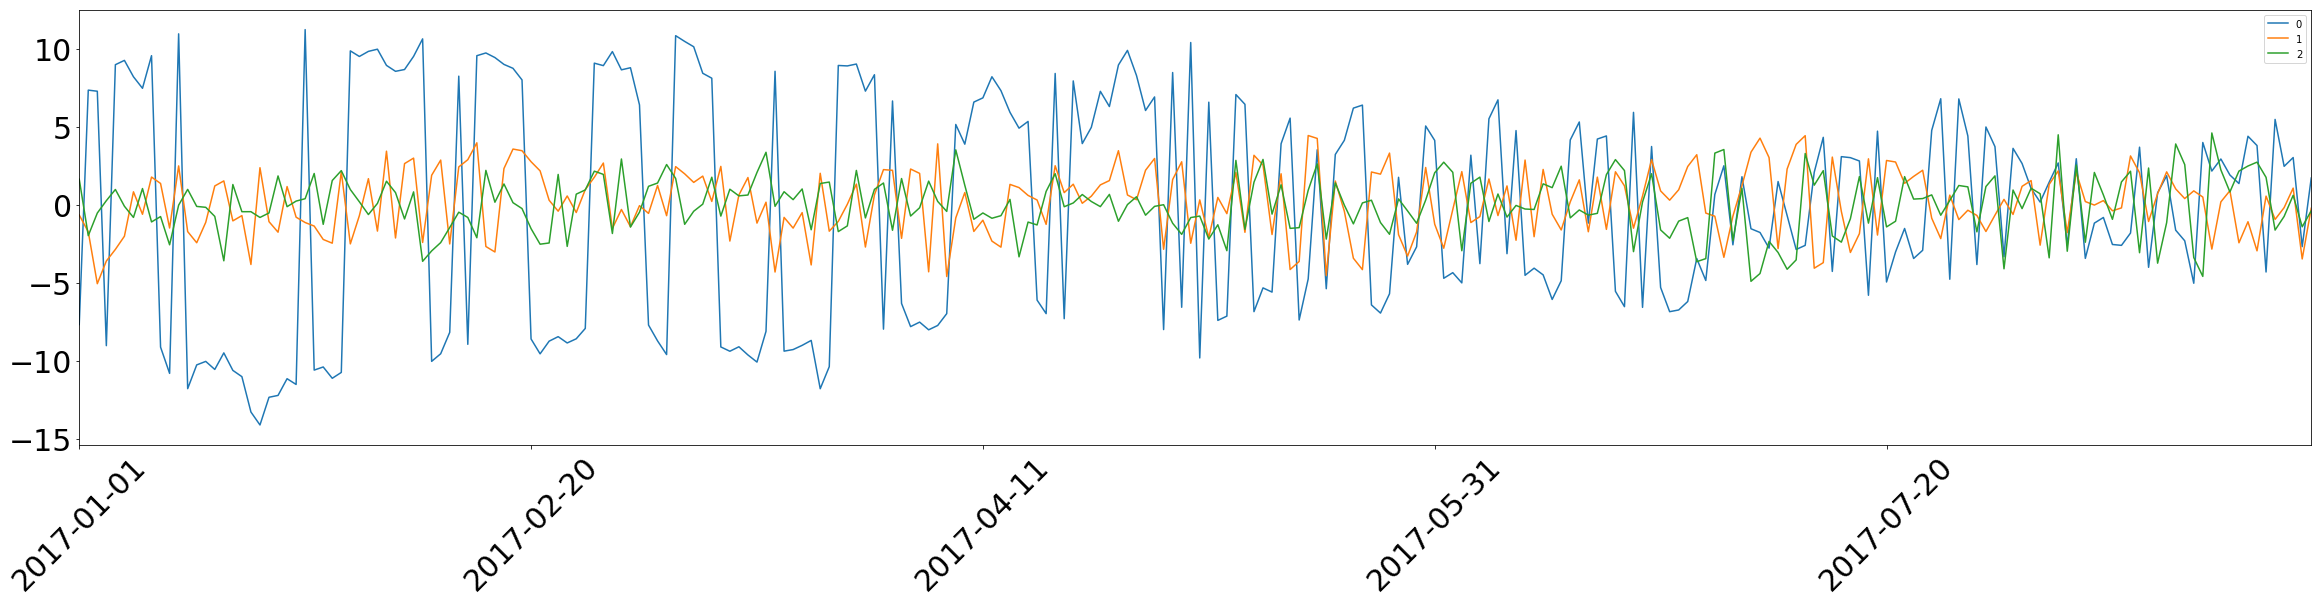

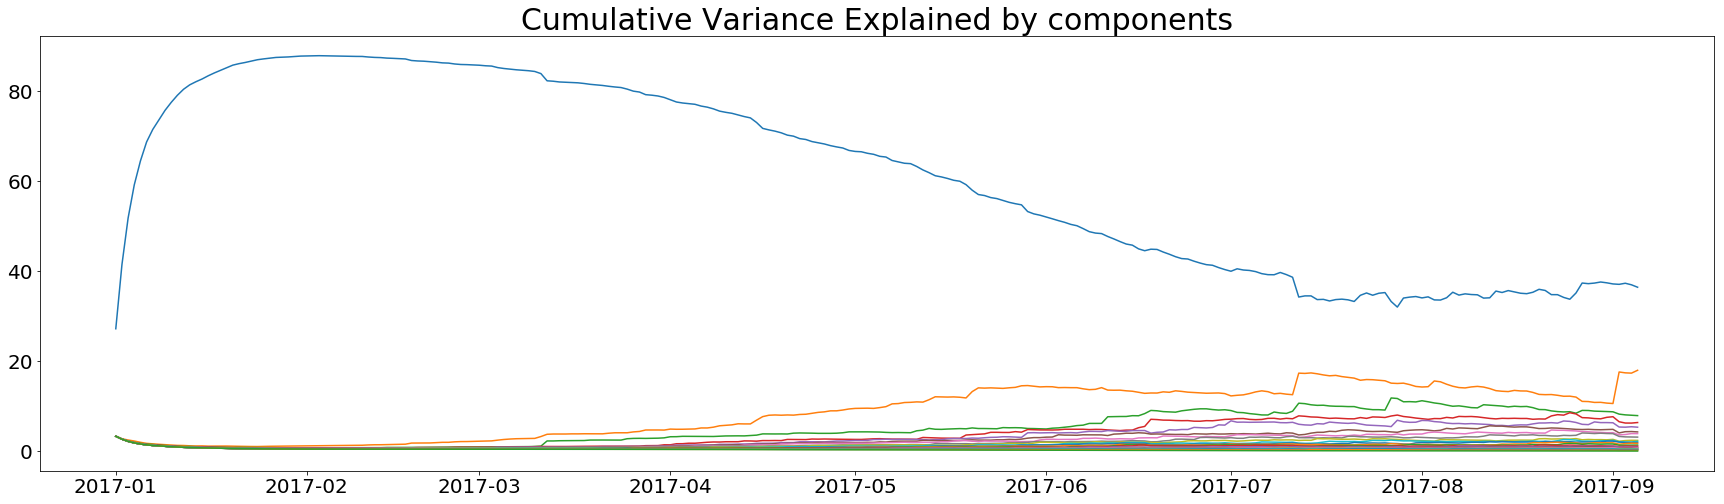

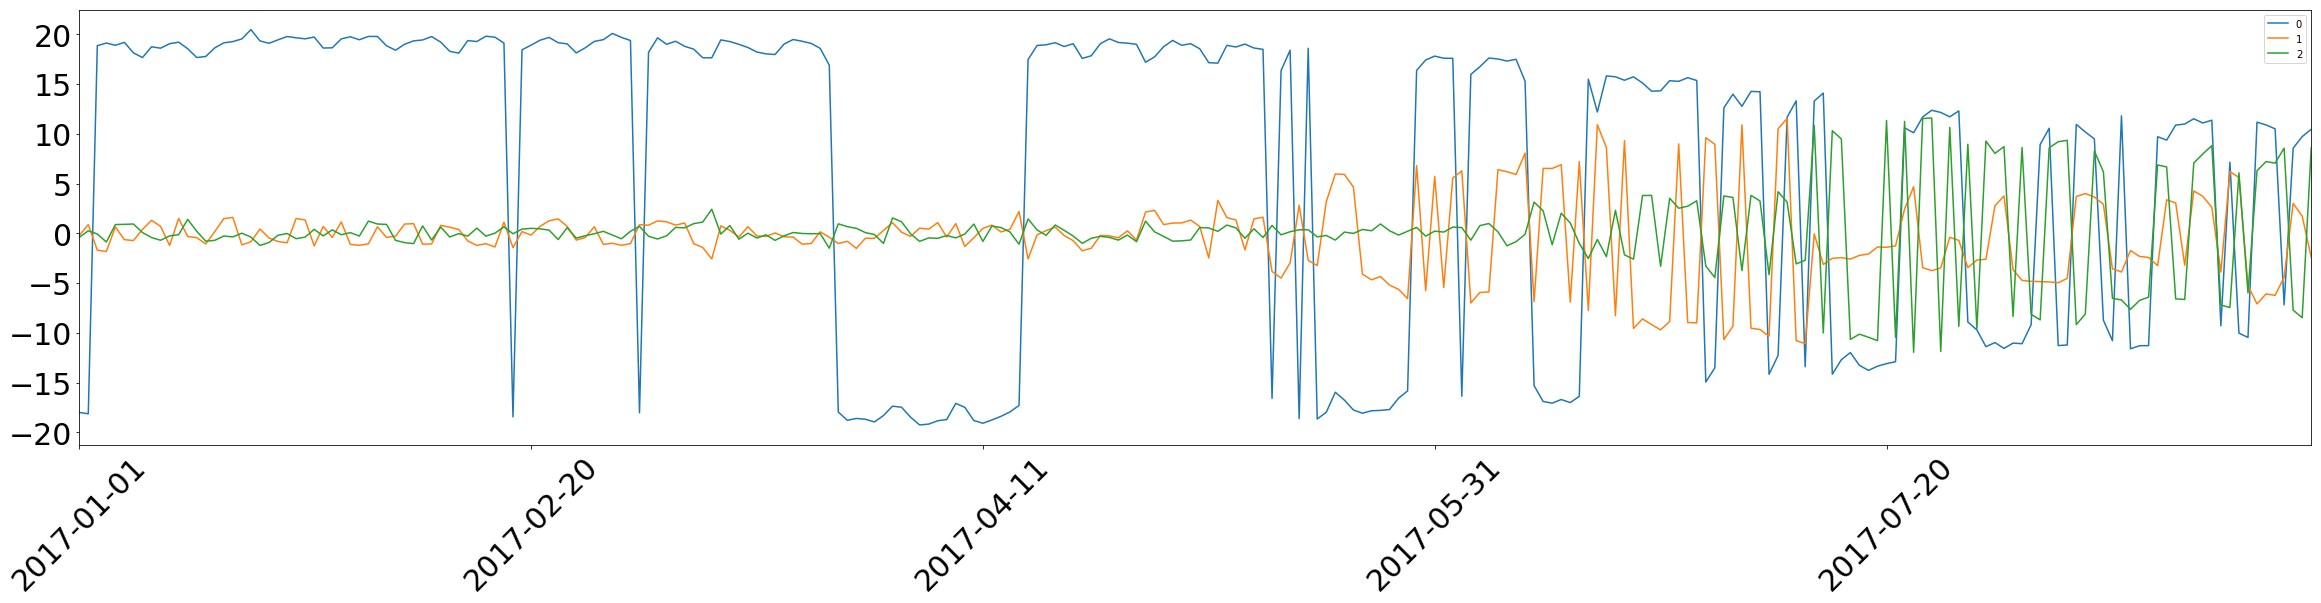

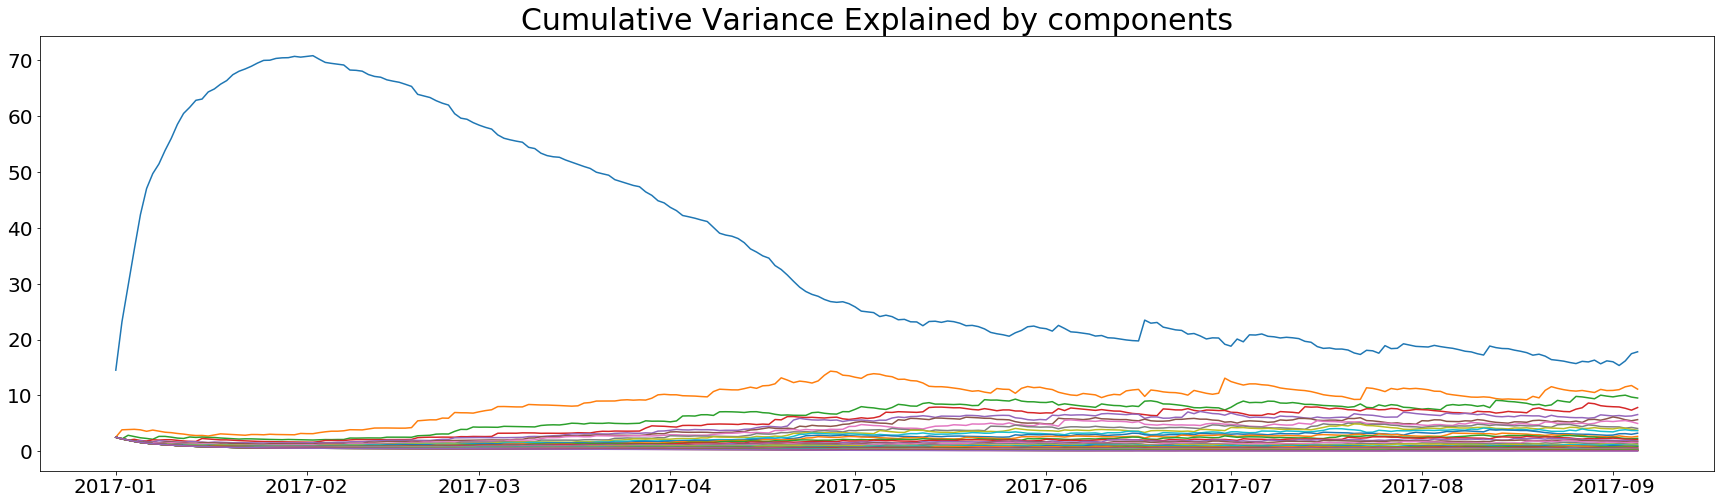

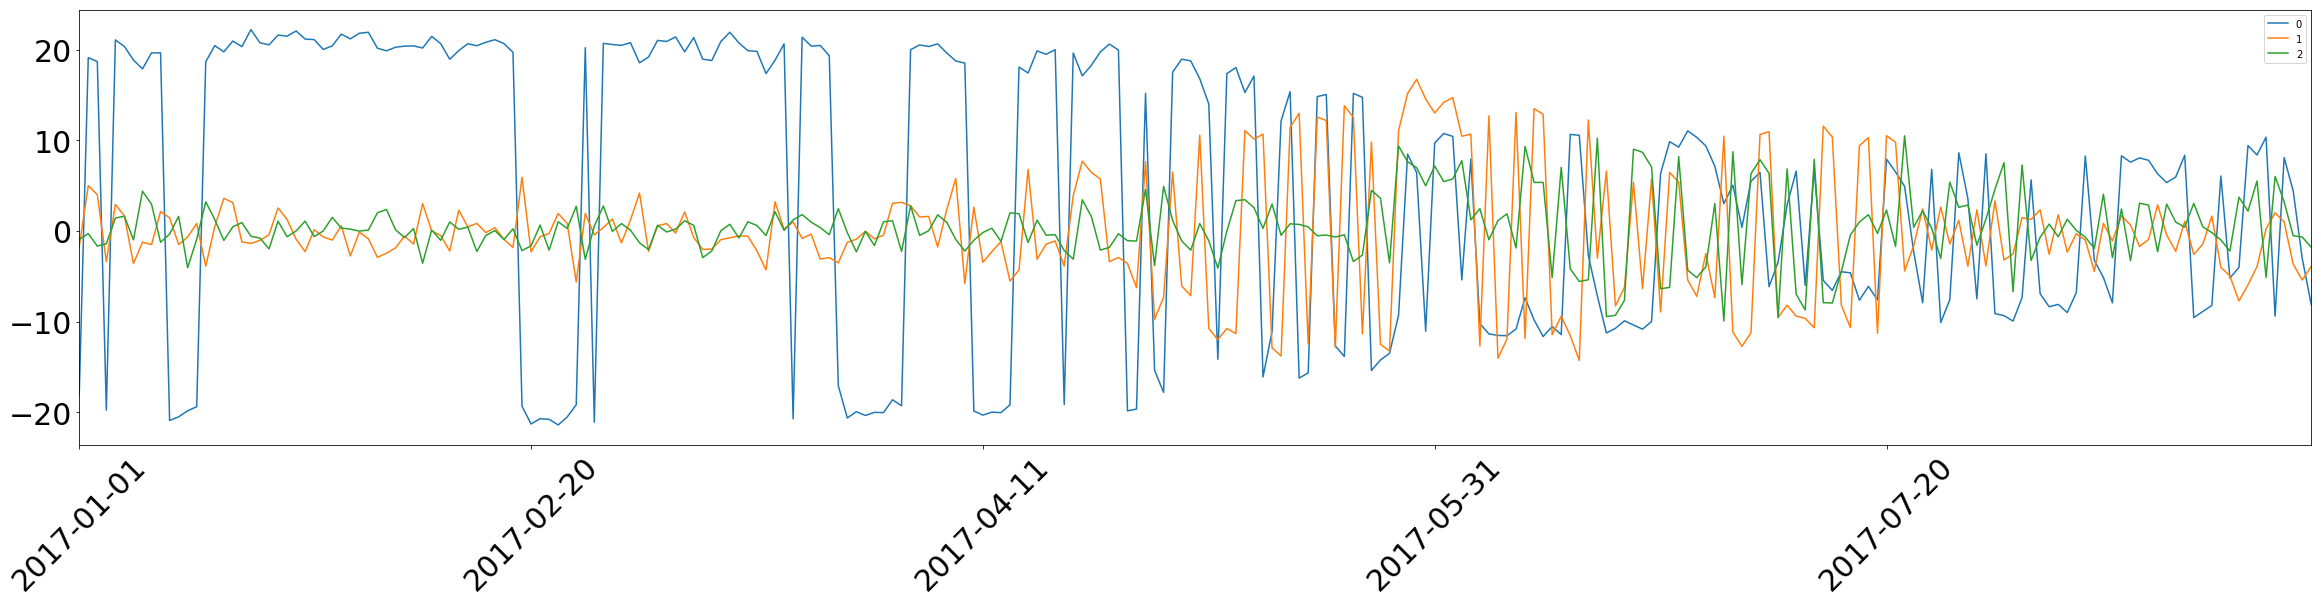

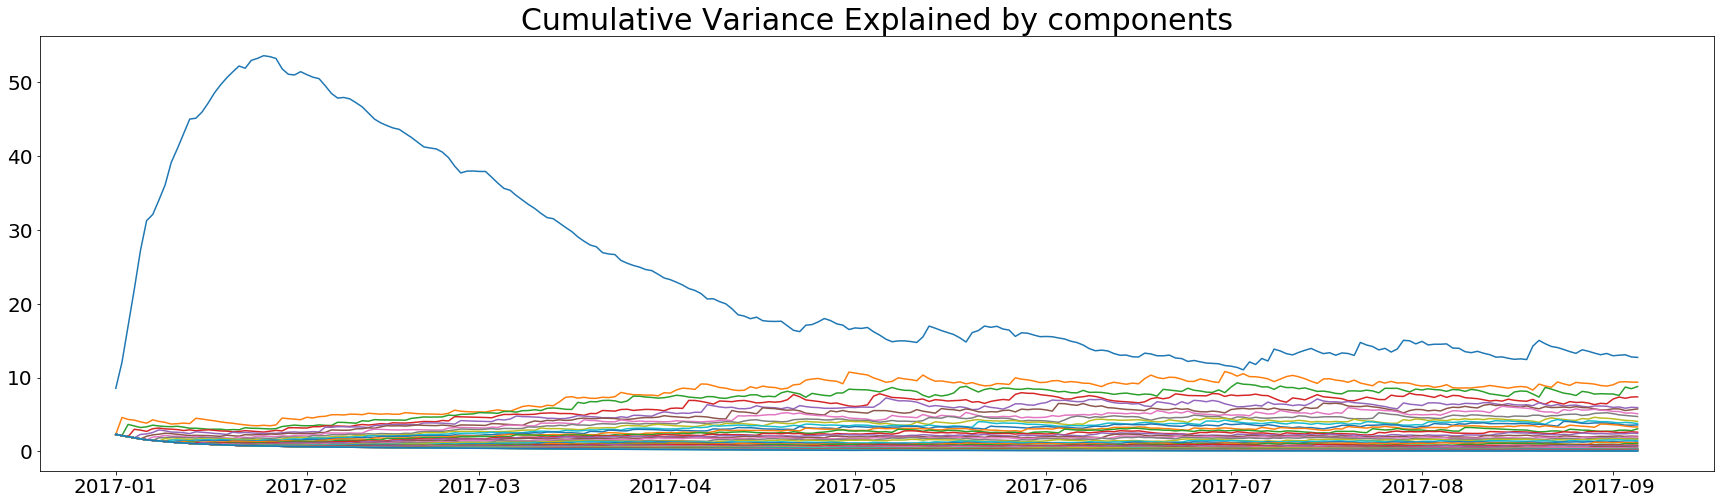

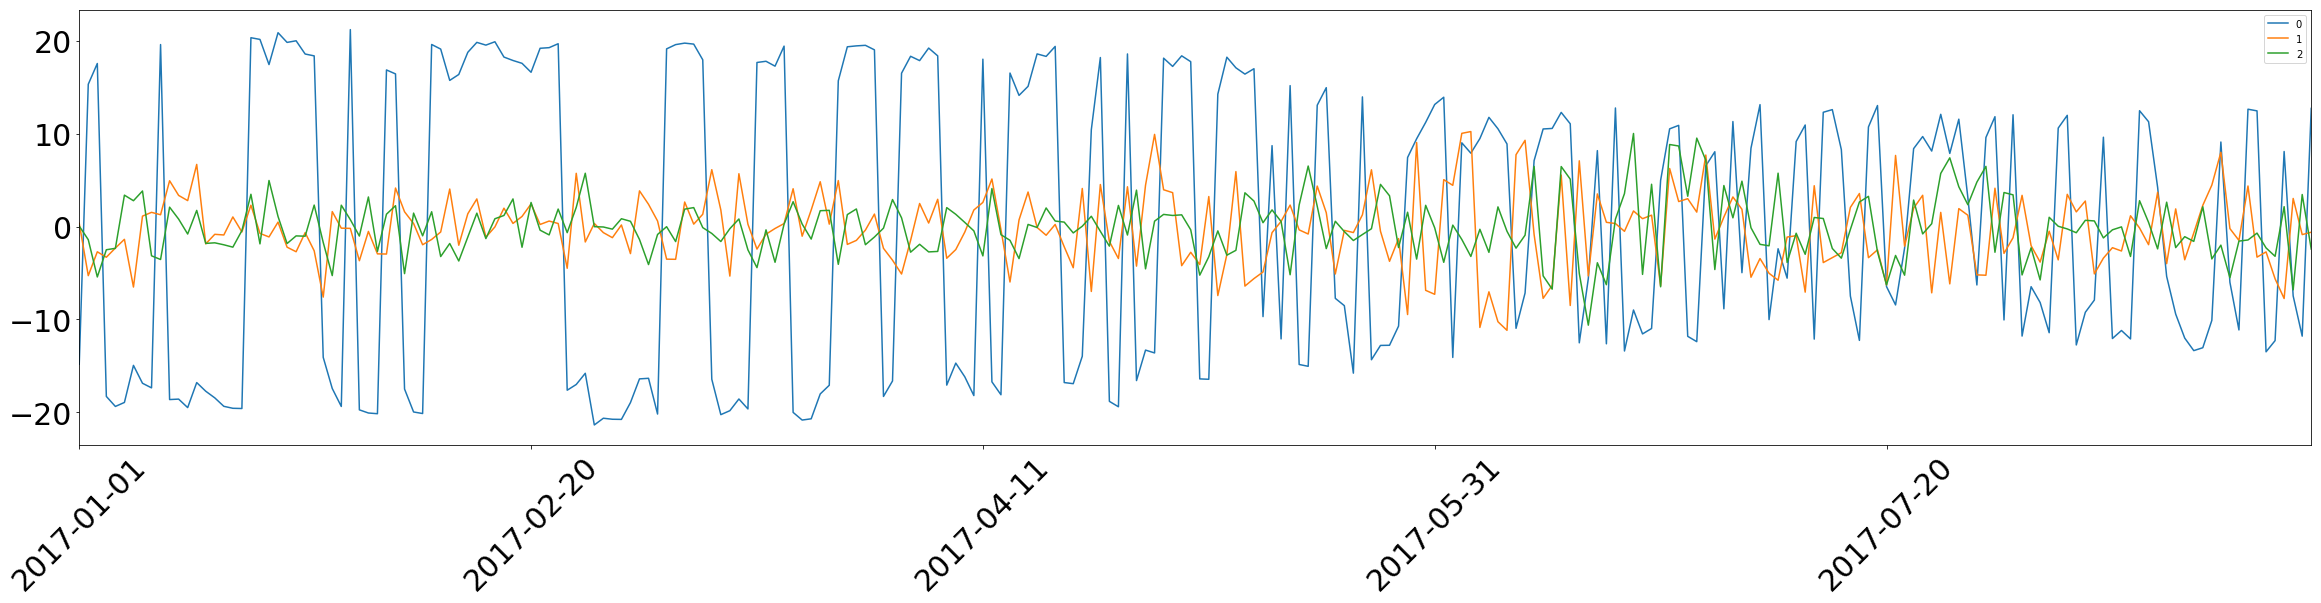

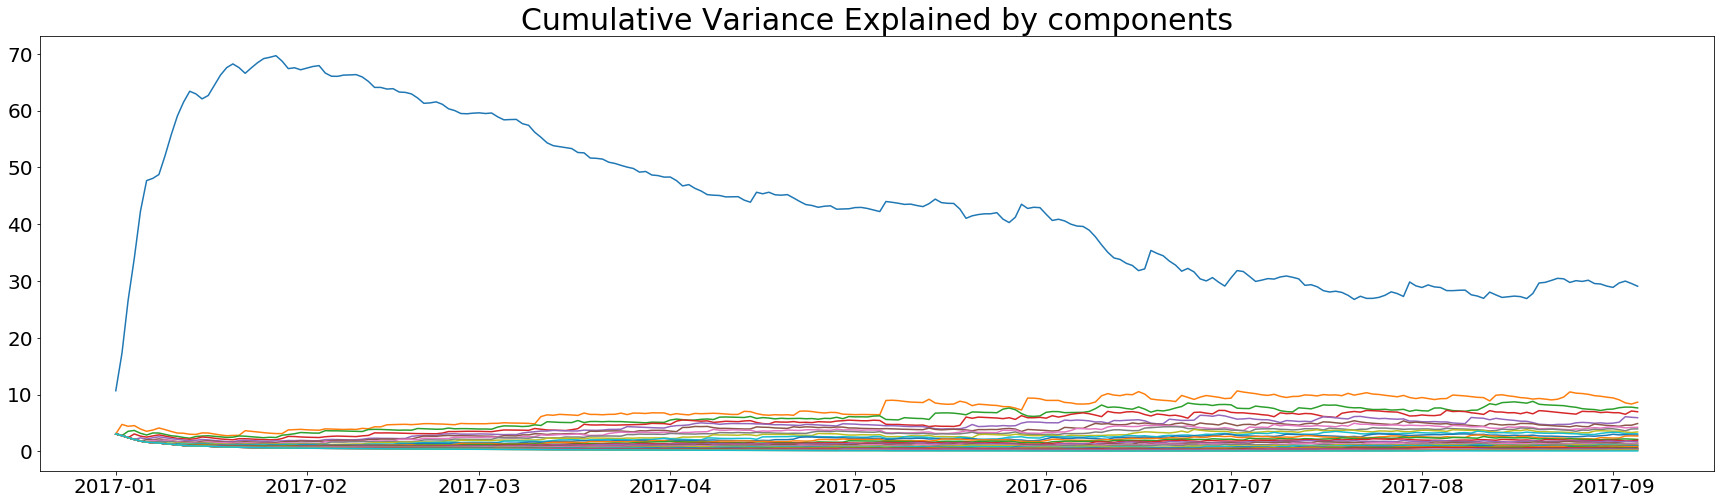

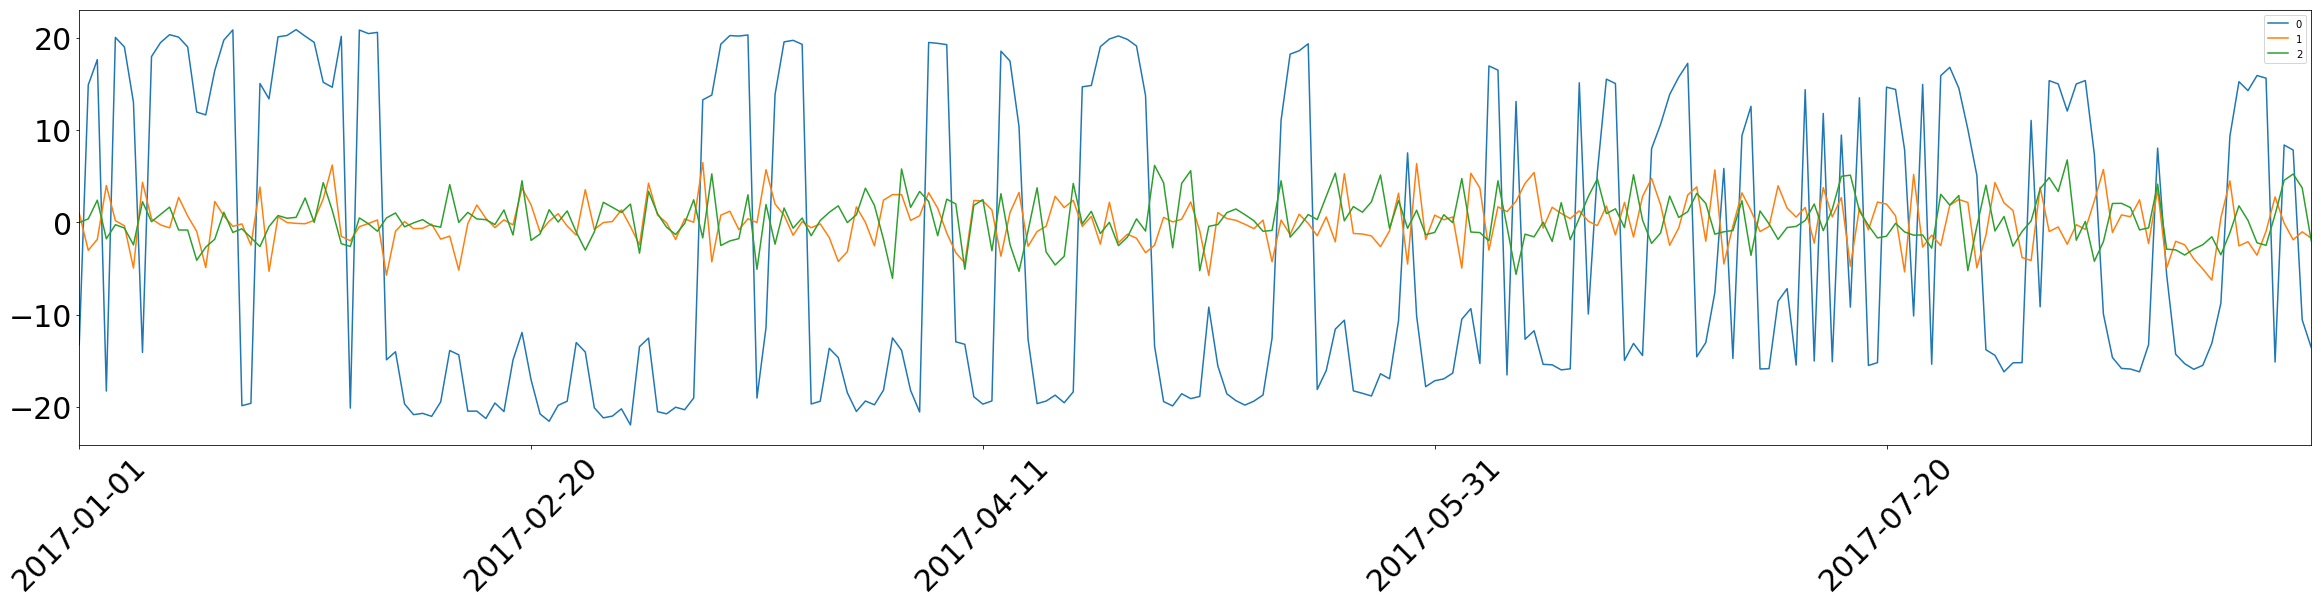

In [198]:
# data for log transformation
df = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/GTdata/df_all_daily_raw.csv', index_col= 0)

for cl_index in cluster.values():
    Y = matrix(df.iloc[:,[i for i in cl_index]])
    T,q = Y.shape
    Y = transpose(Y)
    Y[Y == 0] = 1
    Y = log(Y)
    
    model = multi_filtering(Y = Y , m0 = matrix(np.ones([1,q])),beta = 0.97, delta = 0.9, backwardSmooth = False,Print = False)
    sSt = model.sSt
    sdCt = model.sdCt
    sMt = model.sMt
    sloglik = model.sloglik
    eigs = model.eigs
    eigs_vec = model.eig_vec
    
    eigs_frac = 100*eigs/np.sum(eigs,axis = 0)
    plt.figure(figsize=(30,8))
    for i in range(eigs_frac.shape[0]):
        plt.plot(Date,eigs_frac[i,:])
        plt.tick_params(labelsize=20)
        plt.title('Cumulative Variance Explained by components', fontsize = 30)

    
    component = project_component(Y,eigs_vec,3)
    df_component = pd.DataFrame(component)
    df_component.index = df.index
    df_component.plot(figsize=(40,8),fontsize = 30, rot = 45)
    

In [56]:
dff = pd.DataFrame(component)
dff.index = date

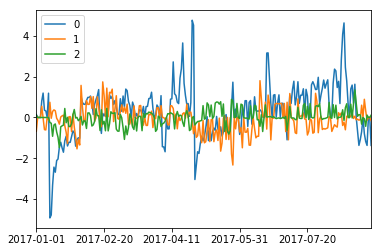

In [61]:
dff.plot()

In [ ]:
np.matrix(transpose(Mt) @ F[:,t])

In [ ]:
m0  = matrix(np.ones([1,q]))
F=np.matrix(np.ones([1,T]));

In [ ]:
ft = np.matrix(transpose(m0) @ F[:,0])

['2017-01-01',
 '2017-01-02',
 '2017-01-03',
 '2017-01-04',
 '2017-01-05',
 '2017-01-06',
 '2017-01-07',
 '2017-01-08',
 '2017-01-09',
 '2017-01-10',
 '2017-01-11',
 '2017-01-12',
 '2017-01-13',
 '2017-01-14',
 '2017-01-15',
 '2017-01-16',
 '2017-01-17',
 '2017-01-18',
 '2017-01-19',
 '2017-01-20',
 '2017-01-21',
 '2017-01-22',
 '2017-01-23',
 '2017-01-24',
 '2017-01-25',
 '2017-01-26',
 '2017-01-27',
 '2017-01-28',
 '2017-01-29',
 '2017-01-30',
 '2017-01-31',
 '2017-02-01',
 '2017-02-02',
 '2017-02-03',
 '2017-02-04',
 '2017-02-05',
 '2017-02-06',
 '2017-02-07',
 '2017-02-08',
 '2017-02-09',
 '2017-02-10',
 '2017-02-11',
 '2017-02-12',
 '2017-02-13',
 '2017-02-14',
 '2017-02-15',
 '2017-02-16',
 '2017-02-17',
 '2017-02-18',
 '2017-02-19',
 '2017-02-20',
 '2017-02-21',
 '2017-02-22',
 '2017-02-23',
 '2017-02-24',
 '2017-02-25',
 '2017-02-26',
 '2017-02-27',
 '2017-02-28',
 '2017-03-01',
 '2017-03-02',
 '2017-03-03',
 '2017-03-04',
 '2017-03-05',
 '2017-03-06',
 '2017-03-07',
 '2017-03-